In [1]:
from read_data import load_dataset, get_synth_data
import matplotlib.pyplot as plt
#from losses import *
import numpy as np
import pickle
from models.ensemble import Ensemble
from models.dropout import Dropout
from models.evidental import Evidental
from models.evidental_gauss import EvidentalGauss
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-07-03 15:07:36.802982: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 15:07:36.854939: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 15:07:36.855671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 15:07:37.616317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from quantilelosses import quant_evi_loss

In [3]:
def get_hparams(dataset, model):
    # open pickle file
    with open('hparams/' + dataset + '/' + model + '.pickle', 'rb') as handle:
        hparams = pickle.load(handle)
    return hparams['params']


datasets = ['boston', 'concrete', 'energy-efficiency', 'kin8nm', 'naval', 'protein', 'power-plant', 'wine', 'yacht']
models = ['dropout', 'ensemble', 'evidental']

for d in datasets:
    print(d)
    for m in models:
        print(get_hparams(d, m))

boston
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 125.8220338018792, 'dropout': 0.39646617693280706, 'lr': 0.004749986842054625}
{'batch_size': 63.756999096332805, 'dropout': 0.4523105646165684, 'lr': 0.0021473655076930625}
concrete
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 94.0045487869605, 'dropout': 0.2144557339801518, 'lr': 0.0011419887532853736}
{'batch_size': 65.11855675430206, 'dropout': 0.1402757486459747, 'lr': 0.00042796586411506654}
energy-efficiency
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.18456270795963, 'dropout': 0.12854472299430145, 'lr': 0.001779653101206466}
{'batch_size': 65.12009140411794, 'dropout': 0.12387115864382735, 'lr': 0.001996240834098853}
kin8nm
{'batch_size': 98.6592345855439, 'dropout': 0.15477179580908645, 'lr': 0.0014895534219560853}
{'batch_size': 98.6

In [4]:
(x_train, y_train), (x_test, y_test), y_train_mu, y_train_scale = load_dataset("concrete")

Loading dataset concrete....
Done loading dataset concrete


In [5]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale<1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

In [198]:
def get_dist(which, x):
    return {
        'Gaussian': tfd.Normal(0,2 * abs(x)+0.2),
        'LogGaussian': tfd.LogNormal(0, 0.25*x),
        'Expo': tfd.Exponential(rate=1/(2 * abs(x)+0.2))
    }[which]


def get_synth_data(name = 'Gaussian', x_min=-4, x_max=4, n=1000, quantiles = [0.5], train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    sigma = 3 * abs(x)+0.2 if train else np.zeros_like(x)
    dist = get_dist(name, x)
    y = x**3 + dist.sample().numpy().astype(np.float32)    

    return x, y, x**3+dist.quantile(quantiles).numpy().astype(np.float32)


In [199]:
x_train, y_train, y_train_q95 = get_synth_data('Gaussian', x_min=-4,x_max= 4, n=1000, train=True, quantiles=[0.05, 0.95])
x_test, y_test, y_test_q95 = get_synth_data('Gaussian', -4, 4, n=1000, train=True, quantiles=[0.05, 0.95])

x_plot, y_plot,  _ = get_synth_data('Gaussian', -7, 7, n=100, train=True)

x_train, x_train_mu, x_train_scale = standardize(x_train)
x_test = (x_test - x_train_mu) / x_train_scale

x_plot = (x_plot - x_train_mu) / x_train_scale

y_train, y_train_mu, y_train_scale = standardize(y_train)
y_test = (y_test - y_train_mu) / y_train_scale
y_plot = (y_plot - y_train_mu) / y_train_scale


In [200]:
#hpara = get_hparams("boston", "evidental")
Evi = Evidental(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            coeff=3e-1,
            learning_rate=3e-3,
            patience=250)


eve_g = EvidentalGauss(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.0,
            learning_rate=3e-3,
            patience=50)

#hpara = get_hparams("boston", "dropout")
Drop = Dropout(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)

#hpara = get_hparams("boston", "ensemble")
Ense = Ensemble(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)


print(Evi.drop_prob)
print(Drop.drop_prob)
print(Ense.drop_prob)

0.1
0.1
0.1


In [201]:
#eve_g.train(x_train, y_train, batch_size=128, epochs=1000)
Drop.train(x_train, y_train, batch_size=128, epochs=1000)
#Ense.train(x_train, y_train, batch_size=128, epochs=1000)
Evi.train(x_train, y_train, batch_size=128, epochs=1000)

Restoring model weights from the end of the best epoch: 448.
Epoch 698: early stopping
Restoring model weights from the end of the best epoch: 107.
Epoch 357: early stopping


In [202]:
print("Evidence: ", Evi.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_train, y_train, y_train_mu, y_train_scale))

print("Evidence: ", Evi.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_test, y_test, y_train_mu, y_train_scale))

Evidence:  (1.0650752, 6.610282, 0.0046331524848937985)
Dropout:  (1.1032786, 6.493363, 0.050903069972991946)
Ensemble:  (16.7198, 12.770166, 0.021000874042510987)
Evidence:  (1.0101856, 6.348961, 0.004630446434020996)
Dropout:  (1.0882624, 6.48822, 0.049761271476745604)
Ensemble:  (16.395922, 12.751462, 0.021569013595581055)


In [203]:
#plt.plot(Evi.history.history['val_nll_eval'], c='red', linestyle='--')
#plt.plot(Evi.history.history['nll_eval'], c='red', label='Evidental')
#plt.plot(Drop.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(Drop.history.history['loss'], c='blue', label='Dropout')
#plt.plot(eve_g.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(eve_g.history.history['loss'], c='blue', label='Dropout')
#plt.plot(Ense.history[0].history['val_loss'], c='green', linestyle='--')
#plt.plot(Ense.history[0].hi
# story['loss'], c='green', label='Ensemble')
#plt.legend()
#plt.show()
#plt.plot(Evi.history.history['val_loss'], c='red', linestyle='--')
#plt.plot(Evi.history.history['loss'], c='red', label='Evidental')
#plt.show()

In [204]:
evi_preds = Evi.predict(x_test)
drop_preds = Drop.predict(x_test)
ense_preds = Ense.predict(x_test)

In [205]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
output = eve_g.model(x_test)
mu, v, alpha, beta = tf.split(output, 4, axis=-1)

In [206]:
dist = tfd.Normal(loc=(mu*y_train_scale) + y_train_mu, scale=y_train_scale*np.sqrt(beta/(v*(alpha-1))))

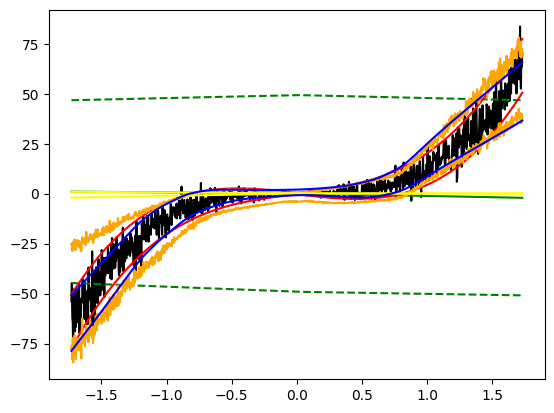

In [207]:
plt.plot(x_test, y_test* y_train_scale + y_train_mu, c='black')
#plt.plot(x_test, mu)
#plt.plot(x_test, mu + 2*np.sqrt(beta/(v*(alpha-1))))
#plt.plot(x_test, mu - 2*np.sqrt(beta/(v*(alpha-1))))
plt.plot(x_test, dist.mean(), c='green')
plt.plot(x_test, dist.quantile([0.95]), '--', c='green')
plt.plot(x_test, dist.quantile([0.05]), '--', c='green')
plt.plot(x_test, y_test_q95[:,0], c='red')
plt.plot(x_test, y_test_q95[:,1], c='red')
plt.plot(x_test, tf.expand_dims(drop_preds[:,1],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_test, tf.expand_dims(drop_preds[:,0],1)* y_train_scale + y_train_mu, c='orange')
plt.plot(x_test, tf.expand_dims(ense_preds[:,1],1)* y_train_scale + y_train_mu, c='yellow')
plt.plot(x_test, tf.expand_dims(ense_preds[:,0],1)* y_train_scale + y_train_mu, c='yellow')
plt.plot(x_test, tf.expand_dims(evi_preds[:,1],1)* y_train_scale + y_train_mu, c='blue')
plt.plot(x_test, tf.expand_dims(evi_preds[:,0],1)* y_train_scale + y_train_mu, c='blue')
#plt.ylim(-5, 75)

In [208]:
errors_evi = (y_test_q95-(evi_preds* y_train_scale + y_train_mu))
errors_drop = (y_test_q95-(drop_preds* y_train_scale + y_train_mu))
#errors_gauss = (y_test_q95-(dist.quantile([0.05, 0.95])))

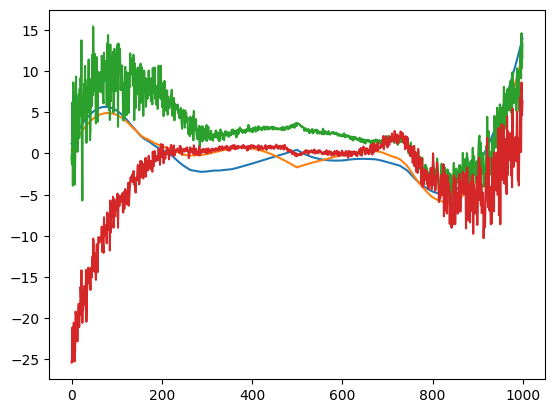

In [209]:
plt.plot(errors_evi)
plt.plot(errors_drop)

In [210]:
expected = np.arange(41)/40
def plot_(model, label, axis, evi=False):
    expected = np.arange(101)/100
    #sigma = model.get_uncertainties(x_train)[:,1]
    #mu = model.predict(x_train)[:,1]
    mu, _ = model.get_mu_sigma(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    mu = mu[:,axis]
    sigma = model.get_uncertainties(x_test)*y_train_scale
    sigma = sigma[:,axis]
    #if evi:
        #sigma = tf.math.sqrt(sigma)
    pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    target = y_test_q95[:,axis]
    obs_p_list = []
    #plt.plot(mu)
    #plt.plot(mu+sigma)
    #plt.plot(mu-sigma)
    #plt.plot(target, c='black')
    #plt.show()
    for p in expected:
        ppf = pred_dist.quantile(p)
        obs_p = (target < ppf).numpy().mean()
        obs_p_list.append(obs_p)

    calibration_error =  np.abs(expected - obs_p_list).mean()
    print(calibration_error)
    plt.plot(expected, obs_p_list,label=label)

    #plt.plot(expected, expected, c='black', linestyle='--')
    #plt.show()

0.10821782178217822
0.32607920792079215
0.28897029702970295


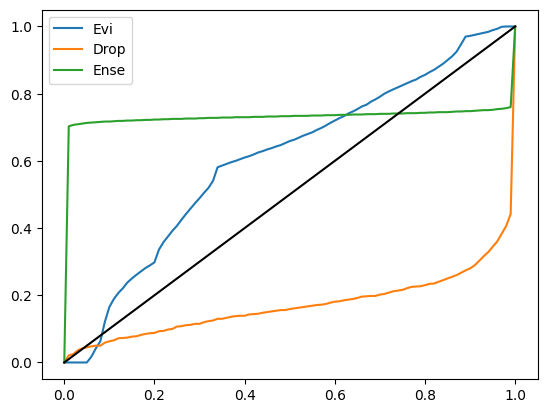

In [211]:
axis = 0
plot_(Evi, label='Evi', axis=axis, evi=True)
plot_(Drop, label='Drop', axis=axis)
plot_(Ense, label='Ense', axis=axis)
plt.plot(expected, expected, c='black')
plt.legend()

In [212]:
mu, _ = Evi.get_mu_sigma(x_plot)
mu = (mu*y_train_scale) + y_train_mu
mu = mu[:,axis]
sigma = Evi.get_uncertainties(x_plot)*y_train_scale
sigma = sigma[:,axis]
#if evi:
    #sigma = tf.math.sqrt(sigma)
pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
target = y_test_q95[:,axis]
obs_p_list = []
#plt.plot(mu)
#plt.plot(mu+sigma)
#plt.plot(mu-sigma)
#plt.plot(target, c='black')
#plt.show()
for p in expected:
    ppf = pred_dist.quantile(p)
    obs_p = (target < ppf).numpy().mean()
    obs_p_list.append(obs_p)

InvalidArgumentError: {{function_node __wrapped__Greater_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100] vs. [1000] [Op:Greater]

In [ ]:
entropy = tf.expand_dims(0.5*np.log(2*np.pi*np.exp(1.)*(sigma**2)),1)

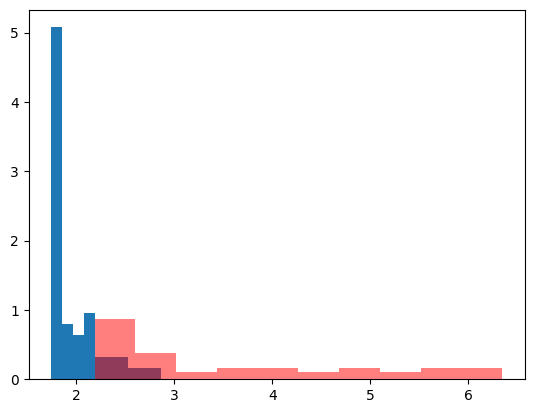

In [ ]:
plt.hist(entropy[(((x_plot*x_train_scale) + x_train_mu) > -4.0) & (((x_plot*x_train_scale) + x_train_mu) < 4.0)], density=True)
plt.hist(entropy[(((x_plot*x_train_scale) + x_train_mu) < -4.0) | (((x_plot*x_train_scale) + x_train_mu) > 4.0)], color='red', alpha=0.5, density=True)
plt.show()

In [160]:
unc_ = np.linspace(entropy[tf.argmin(entropy)[0].numpy()], entropy[tf.argmax(entropy)[0].numpy()], 100)

In [161]:
import scipy

In [162]:
unc.shape

(1000,)

In [163]:
unc = np.sort(entropy.numpy().flatten())
prob = np.linspace(0,1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc)

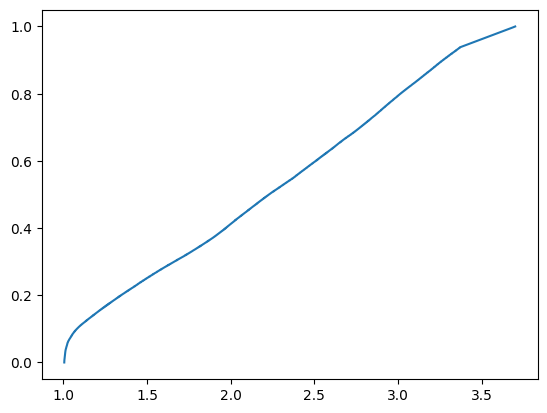

In [164]:
plt.plot(unc, prob_)

In [22]:
print("Evidence")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(evi_preds[:,i],1)).numpy().mean()))

print("Dropout")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(drop_preds[:,i],1)).numpy().mean()))

print("Ensemble")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(ense_preds[:,i],1)).numpy().mean()))


Evidence
The q is 0.05 model have 0.064
The q is 0.95 model have 0.939
Dropout
The q is 0.05 model have 0.024
The q is 0.95 model have 0.965
Ensemble
The q is 0.05 model have 0.048
The q is 0.95 model have 0.955


In [23]:
#print(tf.reduce_mean(y_test-tf.expand_dims(evi_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(drop_preds[:,1],1)**2))
#print(tf.reduce_mean(y_test-tf.expand_dims(ense_preds[:,1],1)**2))

In [24]:
#plt.figure(figsize=(10,10))
#plt.plot(y_test)
#plt.plot(evi_preds[:,0], label='Evidential')
#plt.plot(drop_preds[:,0], label='Evidential')
#plt.scatter(y_test, evi_preds[:,1], label='Evidential')
#plt.scatter(y_test, drop_preds[:,1], label='Dropout')
#plt.scatter(y_test, ense_preds[:,1], label='Ensemble')
#plt.plot(y_test, y_test, label='Ground Truth')
#plt.legend()

In [25]:
def plot_q(x_train, y_train, x_test, y_test, model):
    #mu, var_ = model.get_mu_sigma(x_test)
    mu = model.predict(x_test)
    var_ = model.get_uncertainties(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    var_ = var_*y_train_scale
    y_test = (y_test*y_train_scale) + y_train_mu
    y_train = (y_train*y_train_scale) + y_train_mu
    x_train = (x_train*x_train_scale) + x_train_mu
    x_test = (x_test*x_train_scale) + x_train_mu
    for i, q in enumerate(model.quantiles):
        plot_predictions(x_train, y_train, x_test, y_test, mu[:,i], var=var_[:,i], quantile=q, n_stds=4, kk=i)

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, var, quantile, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    x_train = x_train[:, 0]
    #var = np.minimum(var, 1e3)  # for visualization
    plt.figure(figsize=(5, 3), dpi=200)
    plt.title("Quantile: {:.2f}".format(quantile))
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    #plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.scatter(x_test, y_test, c='r',s=1., zorder=2, label="True")
    plt.plot(x_test, y_pred, color='#007cab', zorder=3, label="Pred")
    #plt.plot(x_test, mu_z, color='green', zorder=3, label="Pred_or")
    #plt.plot(x_test, mu_z+2*std_z, color='green', linestyle='--', zorder=3, label="Pred_or")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

    for k in np.linspace(0, n_stds, 4):
        #print(var.shape)
        #print(mu.shape)
        #print((k*var).shape)
        plt.fill_between(
            x_test, (y_pred - k * var), (y_pred + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    #plt.gca().set_ylim(-5, 5)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


Evidence


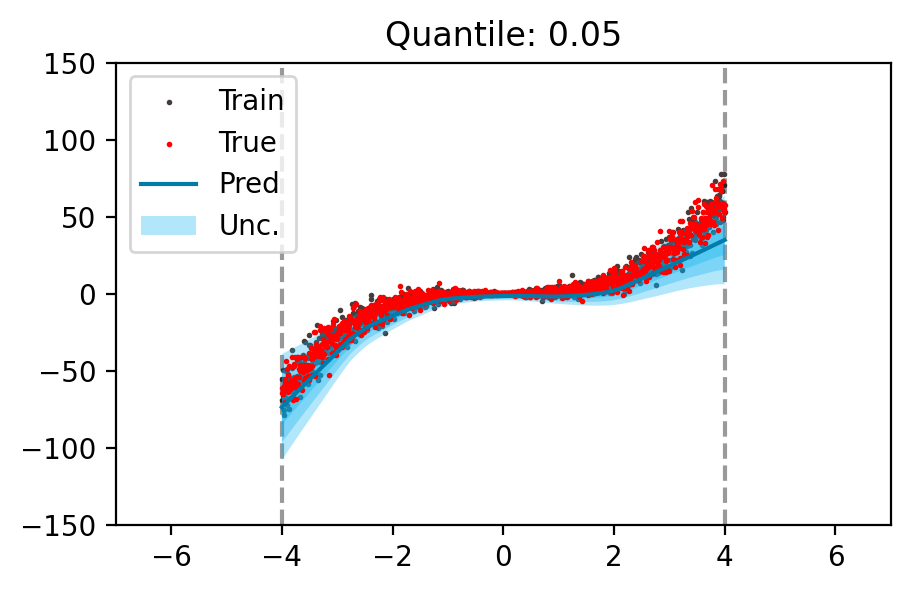

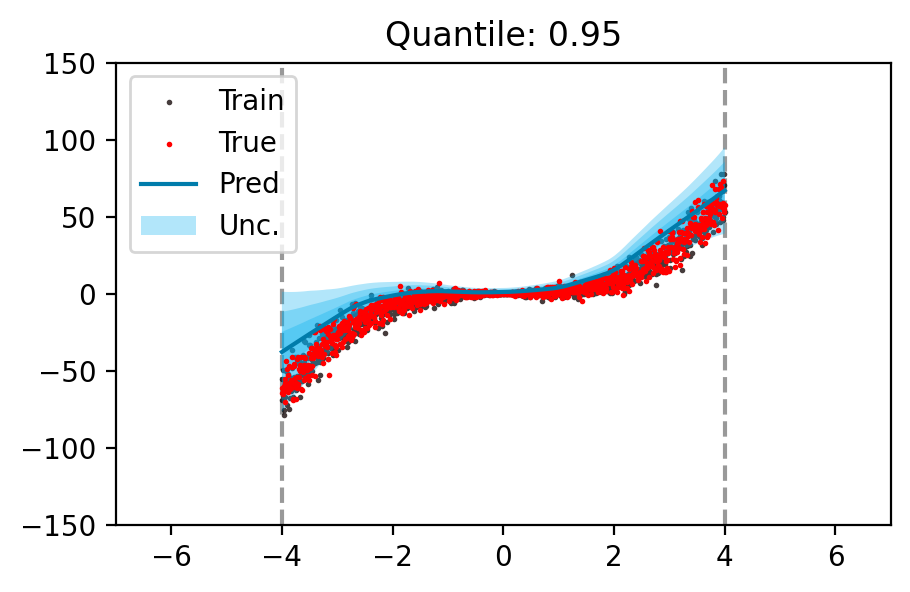

Dropout


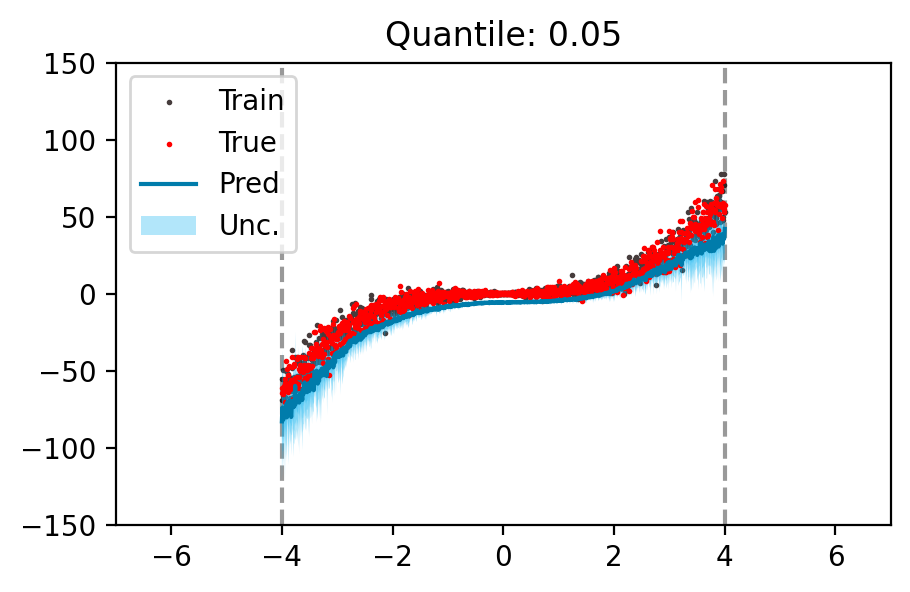

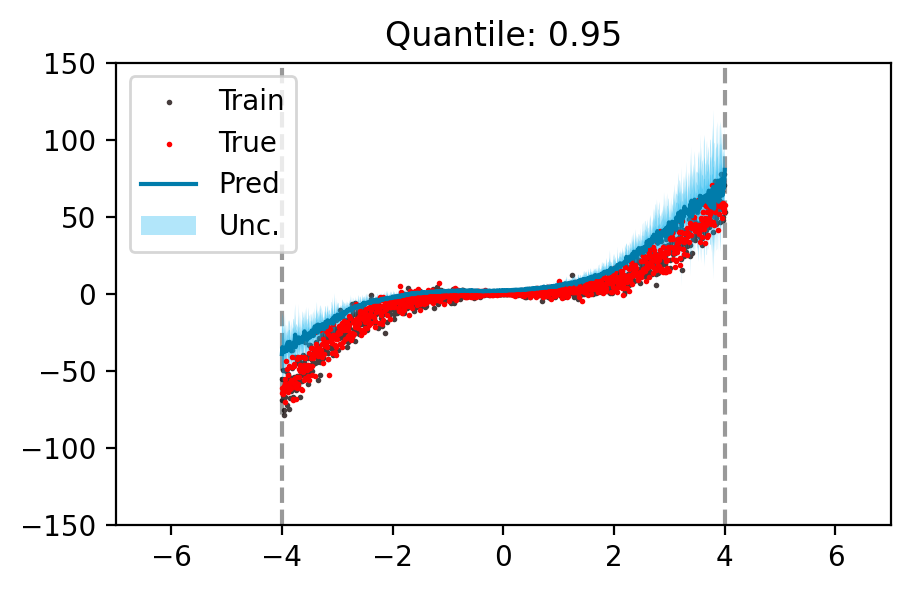

Ensemble


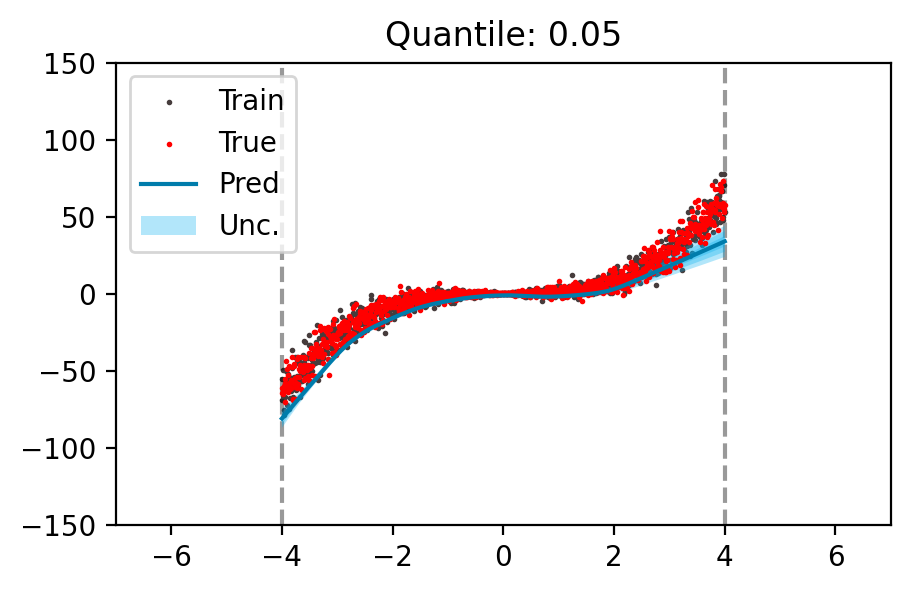

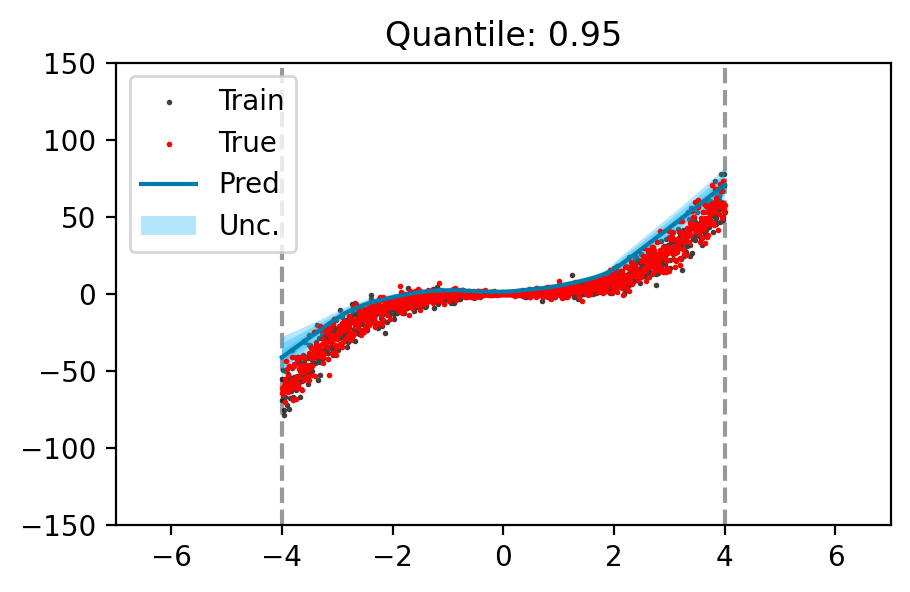

In [26]:
print("Evidence")
plot_q(x_train, y_train, x_test, y_test, Evi)
print("Dropout")
plot_q(x_train, y_train, x_test, y_test, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_test , y_test, Ense)


Evidence


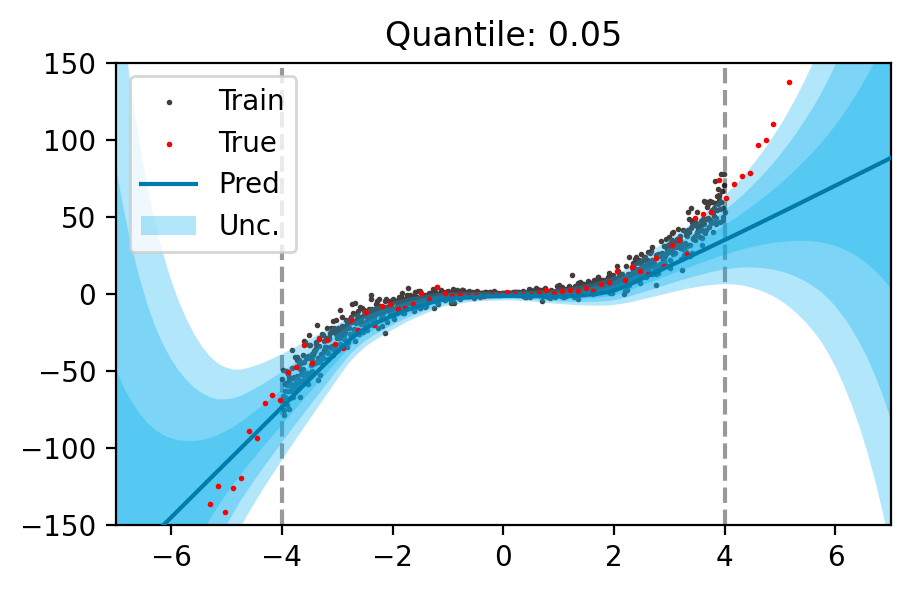

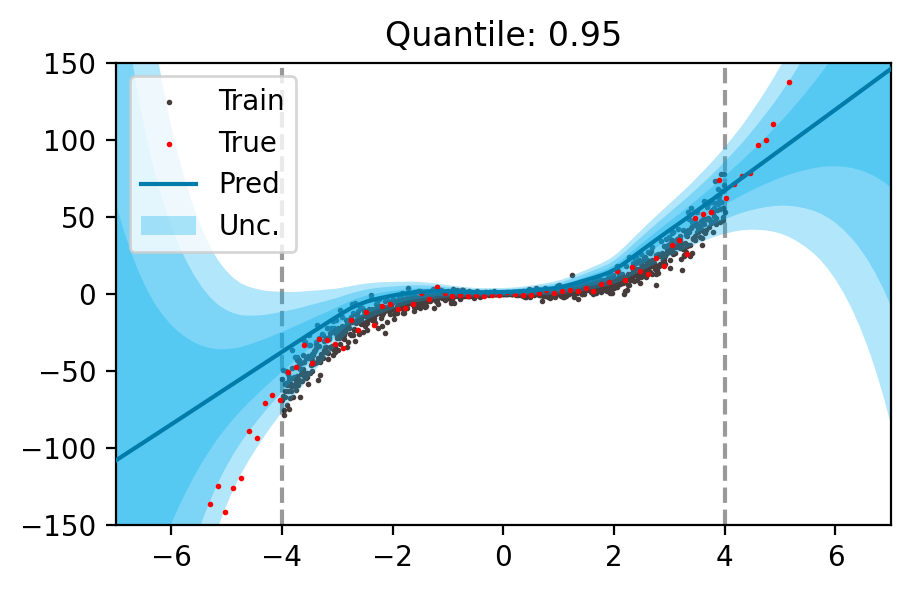

Dropout


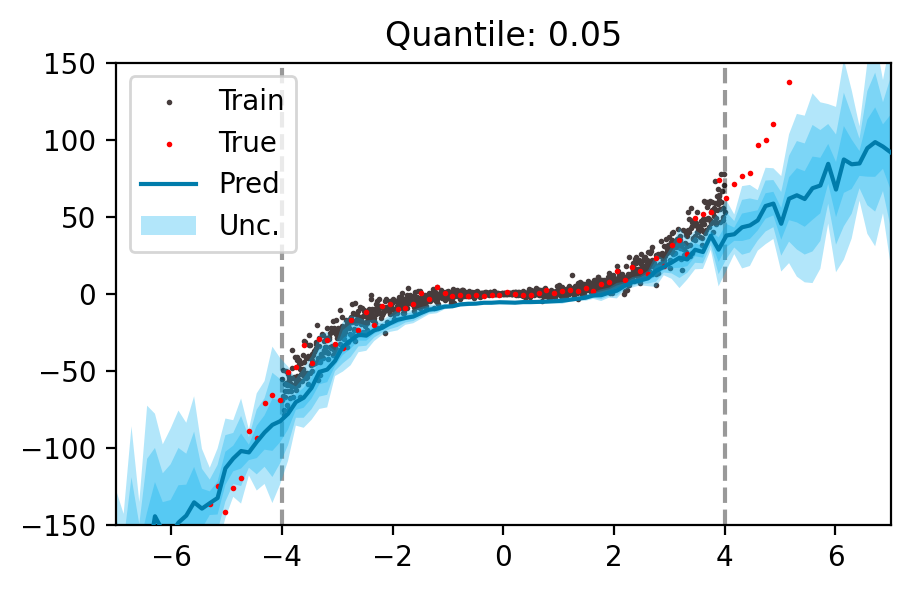

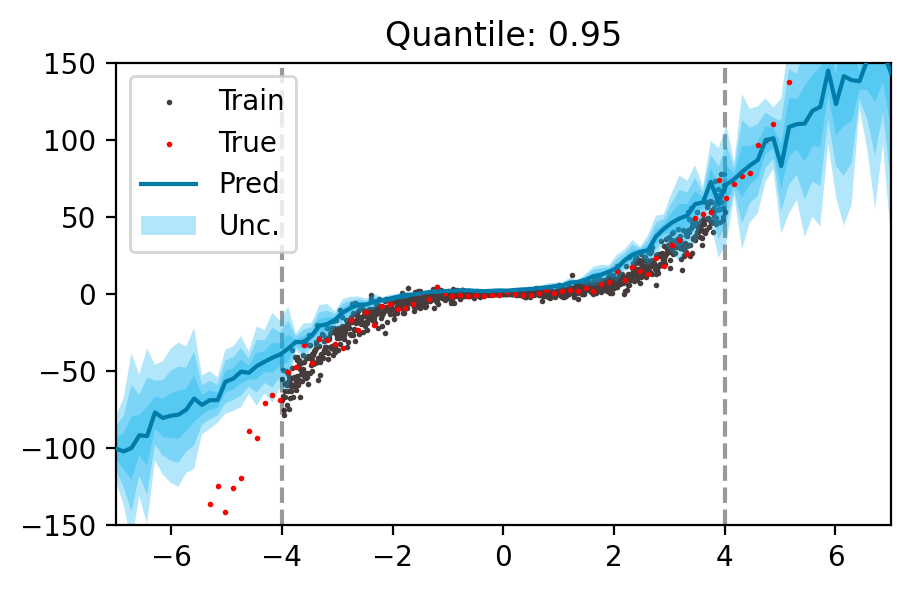

Ensemble


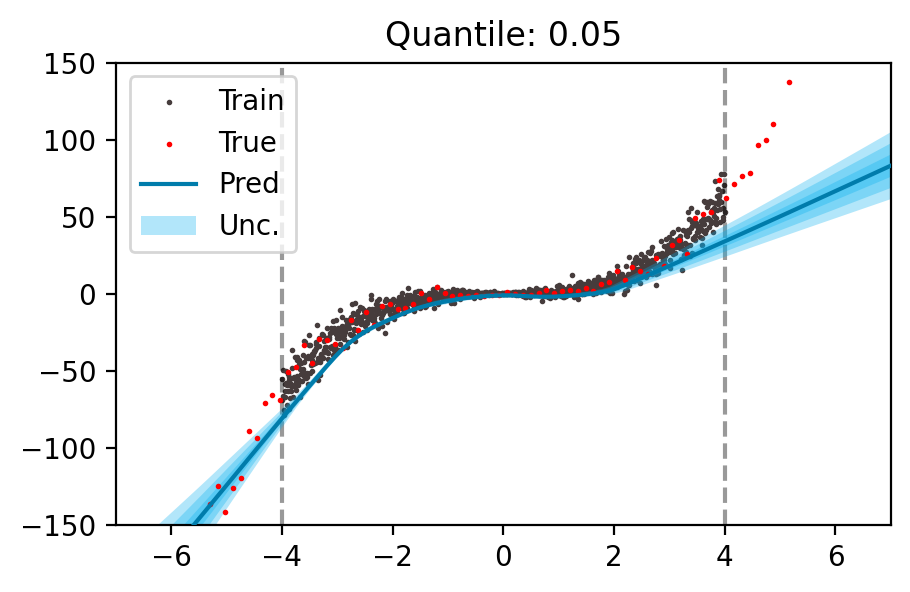

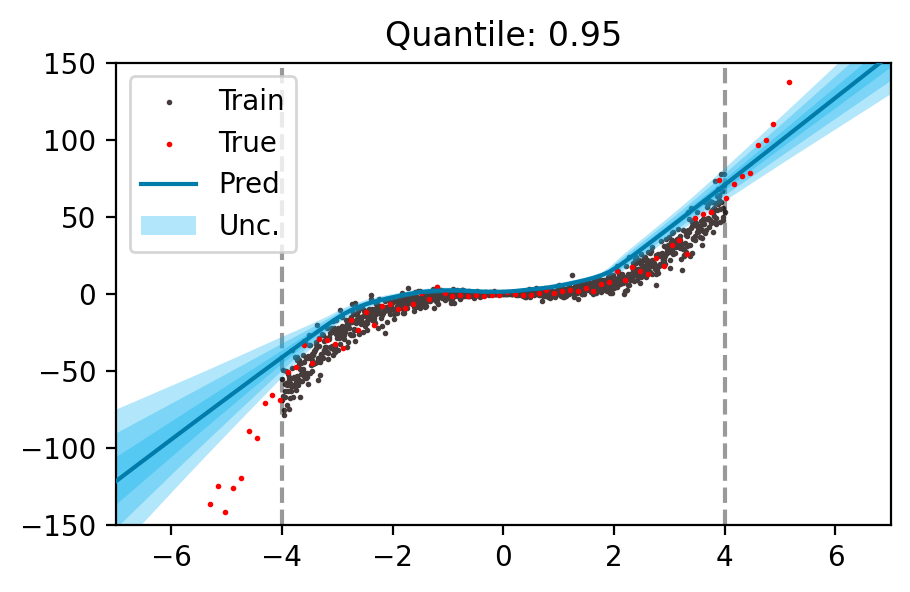

In [27]:
print("Evidence")
plot_q(x_train, y_train, x_plot, y_plot, Evi)
print("Dropout")
plot_q(x_train, y_train, x_plot, y_plot, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_plot, y_plot, Ense)

In [1]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

2023-07-04 11:32:03.286402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-04 11:32:03.286427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)
print(tfp.__version__

2.9.0
0.17.0


In [8]:
from models.evidentalconv import ConvEvidental
from quantilelosses import *

In [9]:
train = h5py.File("data/depth_train.h5", "r")
test = h5py.File("data/depth_test.h5", "r")

In [10]:
x_train, y_train = (train["image"], train["depth"])
x_test, y_test = (test["image"], test["depth"])

In [11]:
#hpara = get_hparams("boston", "evidental")
Evi = ConvEvidental(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            coeff=3e-1,
            learning_rate=3e-4,
            patience=250)

2023-07-04 11:12:03.693943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale<1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

In [13]:
x_train, x_train_mu, x_train_scale = standardize(x_train[:])
x_test = (x_test[:] - x_train_mu) / x_train_scale

y_train, y_train_mu, y_train_scale  = standardize(y_train[:])
y_test = (y_test[:] - y_train_mu) / y_train_scale

In [14]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [15]:
Evi.train(x_train, y_train, batch_size=128, epochs=1)

 74/192 [==========>...................] - ETA: 30:37 - loss: 7.6280 - nll_eval: 8.3094

In [ ]:
preds = Evi.model(x_train[:128])

In [ ]:
example = y_train[:128]

In [ ]:
example.shape

TensorShape([128, 128, 160, 1])

In [ ]:
preds.shape

TensorShape([128, 128, 160, 8])

In [ ]:
mu, v, alpha, beta = tf.split(preds, 4, axis=-1)

In [ ]:
quant_evi_loss(example, tf.expand_dims(mu[:,0], 1), tf.expand_dims(v[:,0],1),
                                tf.expand_dims(alpha[:,0],1), tf.expand_dims(beta[:,0],1), 0.05, 
                                coeff=1e-2)#5e-2)#1e-2)

<tf.Tensor: shape=(), dtype=float32, numpy=43.022945>

In [ ]:
loss = 0.0
mu, v, alpha, beta = tf.split(output, 4, axis=-1)
for i, q in enumerate(self.quantiles):
    loss += quant_evi_loss(y, tf.expand_dims(mu[:,i], 1), tf.expand_dims(v[:,i],1),
                                tf.expand_dims(alpha[:,i],1), tf.expand_dims(beta[:,i],1), q, 
                                coeff=self.coeff)#1e-2)#5e-2)#1e-2)
return loss

In [10]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])